# Pegasos Quantum Support Vector Classifier

The purpose of this series of notebooks is to have a better understanding of the Qiskit library.


[Cristian Correa](https://www.linkedin.com/in/cristiancamilocorrea/)

# Feature Map

What we're gonna do is map the location of two types of species from the 2D plane into a higher dimension K
Now what we can do is compute the optimal hyperplane in some higher dimension that can separate the two classes.

This involves computing the distances between our data points within the higher dimensional space, so if K is very large finding these distances can be very computationally expensive. Son simpler thing to do is to use what's called the [Kernel Trick](https://mathworld.wolfram.com/Kernel.html) The kernel is some easily computable function that takes our two data points and gives back a distance. And the kernel can be optimized in order to maximize the distances between our two classes of data. Unfortunately, some kernel matrices are difficult to compute classically. So this is where the Quantum Computer Comes in. If the kernel can not be estimated classically, Quantum Machine Learning shows a lot of promise in being able to use the multidimensional computation space of the quantum computer in order to find the hyperplane. When data is mapped from its input dimension into the [Hilbert Space](https://mathworld.wolfram.com/HilbertSpace.html) of the Quantum Computer it intrinsically is cast into a higher dimensional space. And usually, finding a dividing hyperplane is often only possible in a higher dimension.

![](https://miro.medium.com/max/1400/0*6VMrGr6j0-Dlns6-.png)


There’s another SVM based algorithm that benefits from the quantum kernel method. Here, we introduce an implementation of a another classification algorithm, which is an alternative version to the QSVC available in Qiskit Machine Learning and shown in the “Quantum Kernel Machine Learning” tutorial. This classification algorithm implements the Pegasos algorithm from the paper “Pegasos: Primal Estimated sub-GrAdient SOlver for SVM” by Shalev-Shwartz et al., see: [https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf](https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf).

Let's generate some data:

In [3]:
from sklearn.datasets import  make_blobs

# example dataset

features, labels = make_blobs( n_samples=20, n_features=2, centers=2, random_state=3, shuffle=True )

In [6]:
print(features.shape)
print(labels.shape)

(20, 2)
(20,)


Before using the data, we make sure that it cam be used with a method called "*rotation encoding*". We Also divide the data into two sets: training data and test data will be used to train a model, and the tes data will be used to evaluate the model's performance.

>Rotation encoding is a feature representation technique used in machine learning, especially in computer vision. In computer vision, images are often treated as arrays of pixels and rotated images are often considered as new, distinct data points. However, this leads to an exponential increase in the size of the dataset, which can result in overfitting and reduced performance.

> To address this, rotation encoding transforms the original image into a feature representation that encodes rotational information in a compact manner. The idea is to extract features that are invariant to rotations, so that the same feature is obtained for the original image and its rotations. This results in a much smaller feature space, which is more efficient for machine learning algorithms to learn from.






In [12]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler

features = MinMaxScaler( feature_range=(0, np.pi) ).fit_transform(features)
print(features.shape)

train_features, test_features, train_labels, test_labels = train_test_split(
 features, labels, train_size=15, shuffle=False
)

(20, 2)


We have two features in the dataset, so we set a number of qubits to the number of features in the dataset.

Then we set $t$ to the number of steps performed during the training procedure. Please note that there is no early stopping criterion in the algorithm. The algorithm iterates over all $t$ steps.

And the last one is the hyperparameter $C$. This is a positive regularization parameter. The strength of the regularization is inversely proportional to $C$. SMALLER $C$ induces smaller weights which generally helps prevent overfitting. However, due to the nature of this algorithm, some of the computation steps become trivial for larger $C$. THUS, LARGER $C$ improves the performance of the algorithm drastically. If the data is linearly separable in feature space, $C$ should be chosen to be large. If the separation is not perfect, $C$ should be chosen smaller to prevent overfitting.

$C$  "C" refers to the regularization parameter in a binary classification problem that helps prevent overfitting. It controls the tradeoff between fitting the training data and minimizing the magnitude of the weights in the classifier.

$t$  "Tau" refers to a parameter in the quantum version of support vector machines (QSVM) that determines the width of the kernel used to map data into a higher-dimensional feature space. It controls the smoothness of the decision boundary and can be adjusted to improve the classification accuracy of QSVM.

In [13]:
# number of qubits is equal to the number of features

num_qubits = 2

# number of steps performed during the traingin procedure
tau = 100

# regularization parameter
C = 100

The algorithm will run using:

* The default fidelity instantiated in `FidelityQuantumKernel`
* A quantum kernel created from `ZFeatureMap`

In [14]:
from qiskit import  BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import  algorithm_globals

from qiskit_machine_learning.kernels import  FidelityQuantumKernel

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits , reps=1)

qkernel = FidelityQuantumKernel(feature_map=feature_map)

In [20]:
print(feature_map)

     ┌─────────────────────────┐
q_0: ┤0                        ├
     │  ZFeatureMap(x[0],x[1]) │
q_1: ┤1                        ├
     └─────────────────────────┘


The implementation PegasosQSVC is compatible with the `scikit-learn` interfaces and has pretty standard way of training model. In the constructor we pass parameters of the algorithm, in this case there are a regularization hyper-parameter $C$ and a number of steps.

Then we pass training features and labels to the fit method. which trains a models and returns a fitted classifier.

Afterwards, we score our model using test features and labels.

In [22]:
from qiskit_machine_learning.algorithms import PegasosQSVC

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel ,C=C, num_steps=tau )

#traingin
pegasos_qsvc.fit(train_features, train_labels)

#testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)

In [26]:
print(f" PegasosQSVC classification test score: {pegasos_score}")

 PegasosQSVC classification test score: 1.0


For visualization purposes we create a mesh grid of a predefined step that spans our minimum and maximum values we applied in MinMaxScaler. We also add some margin to the grid for better representation of the training and test samples.

In [28]:
grid_step = 0.2
margin = 0.2

grid_x, grid_y = np.meshgrid(

 np.arange( -margin, np.pi + margin, grid_step) , np.arange(-margin, np.pi + margin,grid_step)

)

We convert the grid to the shape compatible with the model, the shape should be `(n_samples, n_features)`. Then for each grid point we predict a label. In our case predicted labels will be used for coloring the grid.

In [30]:
meshgrid_features = np.column_stack(( grid_x.ravel(), grid_y.ravel() ))
meshgrid_colors = pegasos_qsvc.predict(meshgrid_features)

Finally, we plot our grid according to the labels/colors we obtained from the model. We also plot traingin and test samples.

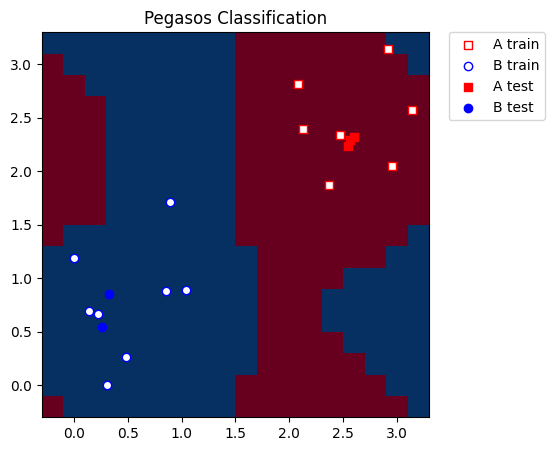

In [40]:
import matplotlib.pyplot as plt

plt.figure( figsize=(5,5) )
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x,grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

plt.scatter(
 train_features[:, 0][train_labels == 0],
 train_features[:, 1][train_labels == 0],
 marker="s",
 facecolors="w",
 edgecolors="r",
 label="A train",
)
plt.scatter(
 train_features[:, 0][train_labels == 1],
 train_features[:, 1][train_labels == 1],
 marker="o",
 facecolors="w",
 edgecolors="b",
 label="B train",
)
plt.scatter(
 test_features[:,0][test_labels == 0],
 test_features[:,1][test_labels == 0],
 marker="s",
 facecolors="r",
 edgecolors="r",
 label="A test",
)
plt.scatter(
 test_features[:, 0][test_labels == 1],
 test_features[:, 1][test_labels == 1],
 marker="o",
 facecolors="b",
 edgecolors="b",
 label="B test",
)

plt.legend( bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0 )
plt.title("Pegasos Classification")
plt.show()

In [42]:
import qiskit.tools.jupyter

%qiskit_version_table